# Business Use Case:
1. In the real estate industry, efficient property listing procedures are essential for enhancing user experience and optimizing marketing efforts. Real estate agencies currently rely on manual classification of properties into different types, a process prone to errors and inconsistencies.
2. This manual approach consumes time and resources, hindering operational efficiency and impacting the accuracy of property information.
3. To address these challenges, there is a need to automate the classification process using text mining techniques applied to descriptions from property listing websites like Daft.ie.
4. By developing a text classification model, real estate agencies can streamline operations, improve listing accuracy, and facilitate targeted marketing efforts.
5. This automation not only enhances user satisfaction and engagement but also enables personalized recommendations by moving away from arbitrary guesses and toward exact algorithms, this change eliminates error-prone manual operations and allows for correct property classification.
6. Automated classification ensures targeted showcasing to the ideal audience, boosting conversion rates and revenue.

# Data Source and Type:
* Source: Daft.ie (property rental website)
* Textual Data: HTML descriptions extracted from property listings
* Total Number of Document(Descriptions) used: 6621 Listings

## Text Classification Task:
* Develop a text classification model to categorize property listings into predefined types (Apartments,  Holiday-Homes, houses, Overseas, Student Accomodation.) based on their descriptions.
* We used three different methods for creating classification models: Logistic Regression, Support Vector Machines (SVM), and Naive Bayes. We also applied TF-IDF for text processing to improve our models' efficacy and accuracy.



In [1]:
#Import all the libraries needed in Python
import requests
import os
import re
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urlparse, parse_qs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import nltk
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from openpyxl import Workbook
from openpyxl import load_workbook
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import seaborn as sns

# You might need to download below to run the code
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

# 1) Data Preparation and Cleaning
The provided Python script utilizes web scraping techniques to extract property data from the Daft.ie website. Extracted data includes property descriptions, links, and address details. This data is then organized into a structured format including columns such as 'Description', 'Link', 'Type', and 'Name'. Each type of listing is then saved into an excel file into different sheets. The sheets are then combined together to form the dataset that would be used for modelling.

In [2]:
class Daft:
    _HEADER = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Content-Type": "application/json",
        "brand": "daft",
        "platform": "web",
    }

    def _init_(self, endpoint):
        # Initialize the class instance with the provided endpoint URL
        self._ENDPOINT = endpoint

    def extract_word_from_url(self, url):
        # Extracts the type of property (e.g., houses, apartments) from the URL
        parsed_url = urlparse(url)  # Parsing the provided URL
        path = parsed_url.path
        path_parts = url.split("/")  # Splitting the URL by '/'
        keyword = ""  # Initializing keyword
        for part in path_parts:
            # Checking for specific keywords in URL parts
            if "houses" in part:
                keyword = "Houses"
                break
            elif "apartments" in part:
                keyword = "Apartments"
                break
            elif "student-accommodation-for-rent" in part:
                keyword = "Student Accommodation"
                break
            elif "overseas" in part:
                keyword = "Overseas"
                break
            elif "holiday-homes" in part:
                keyword = "Holiday Homes"
                break
        return keyword  # Returning the extracted keyword

    def _get_html_content(self, page_num):
        # Fetches HTML content for a specific page number of the property listing
        from_value = (page_num - 1) * 20
        url = f"{self._ENDPOINT}?pageSize=20&from={from_value}"  # Constructing the URL
        response = requests.get(url, headers=self._HEADER)  # Making HTTP GET request

        if response.status_code == 200:  # If request is successful
            return response.content  # Return HTML content
        else:
            print(f"Failed to retrieve HTML content for page {page_num}. Status code: {response.status_code}")
            return None

    def extract_links(self, html_content):
        # Extracts property links from the HTML content
        links = []
        soup = BeautifulSoup(html_content, 'html.parser')  # Parsing HTML content
        results = soup.find_all('li', {'class': 'SearchPagestyled__Result-v8jvjf-2 iWPGnb'})  # Finding all property listings
        for result in results:
            link = result.find('a')['href']  # Extracting link from property listing
            links.append(link)
        return links  # Returning extracted links

    def print_descriptions(self, page_num_range, sheet_name):
        # Scrapes property descriptions, addresses, and links for multiple pages and saves them to an Excel file
        all_data = []  # Initializing list to store all data
        for page_num in range(*page_num_range):  # Iterating over page numbers
            html_content = self._get_html_content(page_num)  # Fetching HTML content
            if html_content:
                links = self.extract_links(html_content)  # Extracting links from HTML content
                for link in links:
                    full_link = f"https://www.daft.ie{link}"  # Constructing full link
                    address, description = self.extract_address_and_description(full_link)  # Extracting address and description
                    property_type = self.extract_word_from_url(self._ENDPOINT)  # Extracting property type
                    all_data.append({'Name': address, 'Link': full_link, 'Description': description, 'Type': property_type})  # Appending data to list
            else:
                print(f"Skipping page {page_num} due to failed HTML retrieval.")
        file_path = 'Property_Descriptions.xlsx'  # Specifying file path
        if os.path.exists(file_path):  # Checking if file already exists
            wb = load_workbook(file_path)  # Loading existing workbook
            if sheet_name in wb.sheetnames:  # Checking if sheet already exists
                with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
                    writer.book = wb
                    df = pd.DataFrame(all_data)  # Creating DataFrame from data
                    df.to_excel(writer, index=False, sheet_name=sheet_name, startrow=wb[sheet_name].max_row)  # Writing DataFrame to Excel
            else:
                with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
                    df = pd.DataFrame(all_data)  # Creating DataFrame from data
                    df.to_excel(writer, index=False, sheet_name=sheet_name)  # Writing DataFrame to Excel
            print(f"{sheet_name} Descriptions saved to Property_Descriptions.xlsx")
        else:
            with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
                df = pd.DataFrame(all_data)  # Creating DataFrame from data
                df.to_excel(writer, index=False, sheet_name=sheet_name)  # Writing DataFrame to Excel
            print(f"{sheet_name} Descriptions saved to Property_Descriptions.xlsx")

    def extract_address_and_description(self, url):
        # Extracts address and description from the property link URL
        response = requests.get(url, headers=self._HEADER)  # Making HTTP GET request
        if response.status_code == 200:  # If request is successful
            soup = BeautifulSoup(response.content, 'html.parser')  # Parsing HTML content
            address_tag = soup.find('h1', {'data-testid': 'address'})  # Finding address tag
            new_address_tag = soup.find('h1', {'data-testid': 'alt-title'})  # Finding alternative address tag
            if address_tag:
                address = address_tag.get_text(strip=True)  # Extracting address text
            elif new_address_tag:
                address = new_address_tag.get_text(strip=True)  # Extracting address text from alternative tag
            else:
                address = "Address not found"  # If address not found
            description_tag = soup.find('div', {'data-testid': 'description'})  # Finding description tag
            if description_tag:
                description = description_tag.get_text(strip=True)  # Extracting description text
            else:
                description = "Description not found"  # If description not found
            return address, description  # Returning address and description
        else:
            print(f"Failed to retrieve content from {url}")  # If request fails
            return None, None  # Returning None for address and description

In [26]:
# Initializing Daft instance for different types of listings
daft_instance = Daft("https://www.daft.ie/property-for-rent/ireland/houses")
daft_instance.print_descriptions((1, 41), 'Housing List')

daft_instance = Daft("https://www.daft.ie/property-for-rent/ireland/apartments")
daft_instance.print_descriptions((1, 46), 'Apartments List')

daft_instance = Daft("https://www.daft.ie/student-accommodation-for-rent/ireland")
daft_instance.print_descriptions((1, 50), 'Student Accommodation List')

daft_instance = Daft("https://www.daft.ie/overseas-properties-for-rent/worldwide")
daft_instance.print_descriptions((1, 101), 'Overseas List')

daft_instance = Daft("https://www.daft.ie/holiday-homes/ireland")
daft_instance.print_descriptions((1, 101), 'Holiday Homes List')

Houses List Descriptions saved to Property_Descriptions.xlsx
Apartments List Descriptions saved to Property_Descriptions.xlsx
Student Accommodation List Descriptions saved to Property_Descriptions.xlsx
Overseas List Descriptions saved to Property_Descriptions.xlsx
Holiday Homes List Descriptions saved to Property_Descriptions.xlsx


In [32]:
# Reading the different Excel file into separate DataFrames in python
df1 = pd.read_excel('Property_Descriptions.xlsx', sheet_name='Housing List')
df2 = pd.read_excel('Property_Descriptions.xlsx', sheet_name='Apartments List')
df3 = pd.read_excel('Property_Descriptions.xlsx', sheet_name='Holiday Homes List')
df4 = pd.read_excel('Property_Descriptions.xlsx', sheet_name='Student Accommodation List')
df5 = pd.read_excel('Property_Descriptions.xlsx', sheet_name='Overseas List')

# Concatenating the DataFrames
combined_df = pd.concat([df1] + [df[1:] for df in [df2, df3,df4,df5]], ignore_index=True)

# Storing the concatenated DataFrame to the same Excel file as a different sheet
with pd.ExcelWriter('Property_Descriptions_1.xlsx', engine='openpyxl', mode='a') as writer:
    combined_df.to_excel(writer, index=False, sheet_name="Listings_Combined")
    print("Combined sheet saved to Property_Descriptions.xlsx")

Combined sheet saved to Property_Descriptions.xlsx


In [7]:
# Loading the Excel file
excel_file = 'Property_Descriptions.xlsx'

Missing descriptions are filtered out from the combined DataFrame.

In [ ]:
df = pd.read_excel(excel_file,sheet_name="Listings_Combined")

# Filtering out rows where the "description is not found"
df = df[df['Description'] != "Description not found"]

# Saving the filtered DataFrame back to Excel
with pd.ExcelWriter('Property_Descriptions.xlsx', engine='openpyxl', mode='a') as writer:
    df.to_excel(writer, index=False, sheet_name="Dataset")
    print("Listings sheet saved to Property_Descriptions.xlsx")

# 2) Data Pre-Processing

In [8]:
# Loading data from the "Dataset" sheet in the Excel file
data = pd.read_excel("Property_Descriptions.xlsx", sheet_name="Dataset", header=None, names=['name','link',"description", "type"])
data = data.iloc[1:]

# Re-setting the index after removing the headers
data.reset_index(drop=True, inplace=True)

print("First few rows of the data:")
print(data.head())  # This prints the first 5 rows by default

First few rows of the data:
                                                name  \
0  St Edmunds Avenue , St Edmunds Avenue , Lucan,...   
1       Occu Belcamp Manor, Belcamp Manor, Dublin 17   
2  Griffith Wood, Griffith Avenue, Drumcondra, Du...   
3        Coopers Cross, Mayor Street Upper, Dublin 1   
4       Opus, 6 Hanover Quay, Hanover Quay, Dublin 2   

                                                link  \
0  https://www.daft.ie/for-rent/st-edmunds-avenue...   
1  https://www.daft.ie/for-rent/occu-belcamp-mano...   
2  https://www.daft.ie/for-rent/griffith-wood-gri...   
3  https://www.daft.ie/for-rent/coopers-cross-may...   
4  https://www.daft.ie/for-rent/opus-6-hanover-qu...   

                                         description    type  
0  **** Stunning Selection of 1st Let, One, Two- ...  houses  
1  Launched in January 2024. _x000D_\n_x000D_\nLi...  houses  
2  Located on the prestigious Griffith Avenue in ...  houses  
3  Ideally located in Dublin's Central Busines

Text data in the description column is preprocessed using techniques like lowercase conversion, removal of special characters, digits, punctuation, tokenization, stopword removal, lemmatization, and removal of specific terms.

In [9]:
# Preprocessing function to process the description text
def preprocess_text(text):
    # Converting text to lowercase
    text = text.lower()
    # Removing special characters, digits, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenizing the text
    tokens = word_tokenize(text)
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatizing the text
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Removing "_x000D_" Words which do not contribute in model building (Below words are chosen by manualling looking at the dataset)
    tokens = [word for word in tokens if word not in['_x000D_', 'xd','de','en','km']]
    # Joining tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Converting all values in 'description' column to strings
data['description'] = data['description'].astype(str)

# Applying preprocessing function to 'description' column
data['description'] = data['description'].apply(preprocess_text)

print("Text data preprocessed.")
print("First few preprocessed descriptions:")
print(data['description'].head())

Text data preprocessed.
First few preprocessed descriptions:
0    stunning selection st let one two threebedroom...
1    launched january life occu meet acre landscape...
2    located prestigious griffith avenue dublin gri...
3    ideally located dublin central business distri...
4    owen reilly delighted present opus hanover qua...
Name: description, dtype: object


# 3) Data Splitting
The data is split into features (X) and labels (y), where the 'description' column serves as the feature set, containing the pre-processed textual descriptions, and the 'type' column serves as the label set, representing the property types. The dataset is then divided into training and testing sets using the train_test_split function from scikit-learn. The parameter 'test_size=0.2' specifies that 20% of the data will be reserved for testing, while the remaining 80% will be used for training.

In [10]:
# Dividing the dataset into features and labels
X = data['description']
y = data['type']

In [11]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True,random_state=42)

# Printing sizes of training and testing sets
print("Data split into training and testing sets.")
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Data split into training and testing sets.
Training set size: 5296
Testing set size: 1325


# 4) Feature Selection
TF-IDF (Term Frequency-Inverse Document Frequency) is employed for text preprocessing, which is a widely used technique in natural language processing (NLP) for converting text data into numerical features. The process begins with converting the raw text descriptions into a matrix representation using CountVectorizer, which counts the occurrence of each word in the text corpus. Then, TF-IDF transformation is applied to this matrix to give more weight to words that are rare across the entire corpus but frequent within specific documents, thereby capturing the importance of each word in the context of individual descriptions. This transformation effectively reduces the impact of common words while highlighting the significance of unique terms in each document. By utilizing TF-IDF, the textual descriptions are transformed into a numerical format suitable for machine learning models, enabling the development of robust classifiers that can effectively classify properties based on their descriptions.

In [12]:
# Initializing TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Computing TF-IDF features
X_tfidf = vectorizer.fit_transform(X_train)

# Storing and printing feature names
feature_names = vectorizer.get_feature_names_out()

print("Total number of features:",len(feature_names))

Total number of features: 18846


Custom features, representing property attributes like 'parkview', 'garage', and 'seaview', are defined. These features are then used to initialize a TF-IDF vectorizer, which converts the textual descriptions into numerical features. This feature selection process enhances the model's ability to capture relevant patterns from the property descriptions, improving its predictive accuracy.

In [13]:
# Defining the custom features without duplicates of various property types
custom_features = [
    'parkview', 'doorstop', 'stovetop', 'utilityroom', 'woodvilla',
    'mountain', 'seaview', 'cowork', 'faculti', 'attic',
    'gym', 'fireplace', 'basement', 'penthouse', 'patio', 'cottage',
    'garden', 'parking', 'garage', 'detached', 'terrace', 'yard',
    'farmhouse', 'villa', 'countryside', 'rural', 'townhouse',
    'bungalow', 'balcony', 'kitchenette', 'condo', 'complex', 'floor',
    'elevator', 'central', 'modern', 'urban', 'downtown', 'high-rise',
    'concierge', 'studio', 'city', 'flat', 'student', 'university',
    'dormitory', 'campus', 'shared', 'furnished', 'roommate', 'study',
    'internet', 'common', 'student-friendly', 'lease', 'term',
    'refurbished', 'lodge', 'seaside', 'ocean', 'beach', 'resort',
    'coastal', 'island', 'scenic', 'tourist', 'exotic', 'tropical',
    'mediterranean', 'international', 'foreign', 'vacation', 'chalet',
    'relaxing', 'tranquil', 'retreat', 'getaway', 'weekend', 'escape'
]
# Initializing TF-IDF vectorizer with selected features
vectorizer_selected = TfidfVectorizer(vocabulary=custom_features)

# Computing TF-IDF features for train data
X_train_tfidf_selected = vectorizer_selected.fit_transform(X_train)

# Transforming TF-IDF features for test data
X_test_tfidf_selected = vectorizer_selected.transform(X_test)

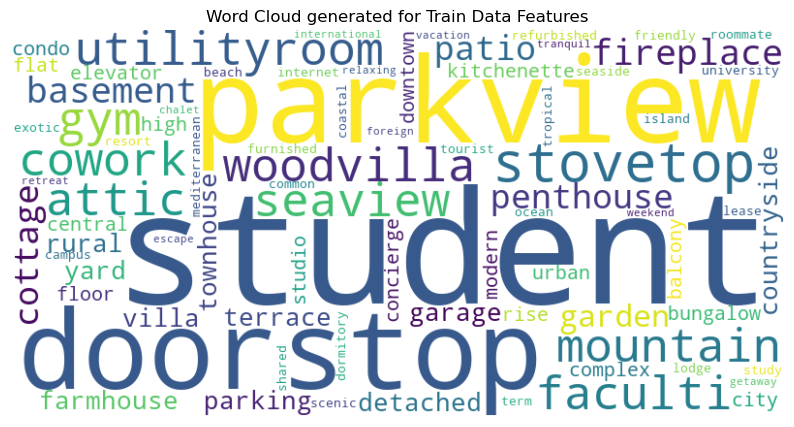

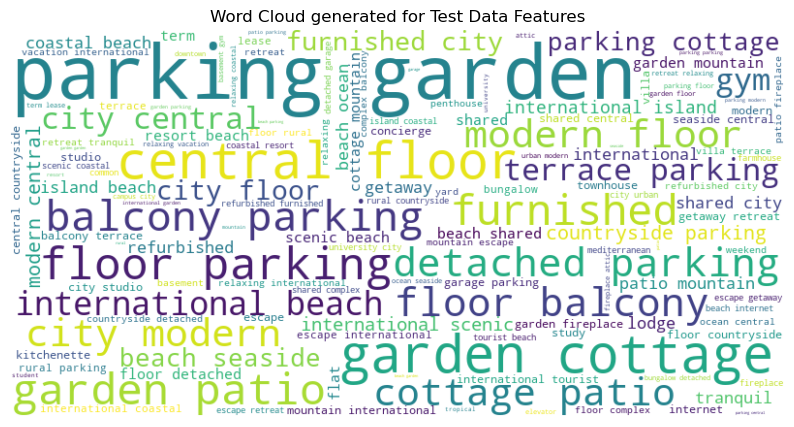

In [14]:
# Function to generate word cloud from TF-IDF features and custom features
def generate_wordcloud(features, title):
    # Combine all features into a single string
    text = ' '.join(features)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Ploting word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Extracting feature names from the TF-IDF vectorizer
feature_names = vectorizer_selected.get_feature_names_out()

# Generating word cloud for train data features
generate_wordcloud(feature_names, "Word Cloud generated for Train Data Features")

# Generating word cloud for test data features
test_feature_names = vectorizer_selected.inverse_transform(X_test_tfidf_selected)
# Removing duplicates
test_features = [feature for sublist in test_feature_names for feature in sublist]
# Generating word cloud
generate_wordcloud(test_features, "Word Cloud generated for Test Data Features")


# 5) Model Selection & Training:
This step involves selecting a machine learning algorithm i.e Support Vector Machine, Naive Bayes, and Logistic Regression and then training the data using the testing and training data.

In [37]:
# Initializing and training the model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf_selected, y_train)

# Save Naive Bayes model using pickle
with open('naive_bayes_model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)

# Load Naive Bayes model from file
with open('naive_bayes_model.pkl', 'rb') as file:
    loaded_model_nb = pickle.load(file)
    
print("NB Model trained successfully.")

NB Model trained successfully.


In [38]:
# Training SVM classifier
svm_classifier = SVC(kernel='linear')  # Linear kernel is often used for text data
svm_classifier.fit(X_train_tfidf_selected, y_train)

# Save SVM Bayes model using pickle
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_classifier, file)

# Load SVM Bayes model from file
with open('svm_model.pkl', 'rb') as file:
    loaded_model_svm = pickle.load(file)

print("SVM Model trained successfully.")

SVM Model trained successfully.


In [39]:
# Training Logistic Regression classifier
logistic_regression = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence warnings are raised
logistic_regression.fit(X_train_tfidf_selected, y_train)

# Save Logistic Regression model using pickle
with open('logr_model.pkl', 'wb') as file:
    pickle.dump(logistic_regression, file)

# Load SVM Bayes model from file
with open('logr_model.pkl', 'rb') as file:
    loaded_model_lr = pickle.load(file)

print("Logistic Regression Model trained successfully.")

Logistic Regression Model trained successfully.


# 6) Model Evaluation:

After the model has been trained and tested, it's performance is then evaluated on certain metrics:
1) Accuracy: Suggests how accurate the model is in classifying the data.
2) Precision: precision focuses on the accuracy of positive predictions A precision score closer to 1.0 indicates that the model has fewer false positives and is making accurate positive predictions.
3) F1_score: F1 score balances precision and recall, especially in imbalanced datasets

Accuracy of Naive Bayes: 61.66 %
Classification Report:
                      precision    recall  f1-score   support

            Overseas       0.76      0.73      0.74       401
Student Accomodation       0.33      0.23      0.27       181
          apartments       0.47      0.48      0.48       179
       holiday-homes       0.64      0.91      0.75       390
              houses       0.58      0.25      0.35       174

            accuracy                           0.62      1325
           macro avg       0.56      0.52      0.52      1325
        weighted avg       0.60      0.62      0.59      1325



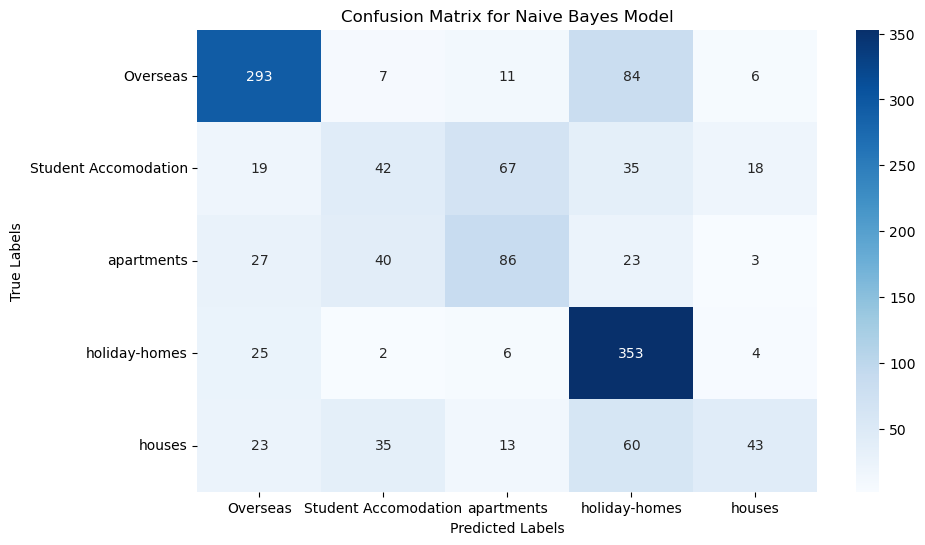

In [18]:
# Evaluating the Naive Bayes model
y_pred = nb_model.predict(X_test_tfidf_selected)
accuracy_nb = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes:", round(accuracy_nb*100,2),"%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix for Naive Bayes Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Accuracy of Support Vector Machine: 70.57 %
Classification Report:
                      precision    recall  f1-score   support

            Overseas       0.80      0.89      0.84       401
Student Accomodation       0.32      0.19      0.24       181
          apartments       0.42      0.65      0.51       179
       holiday-homes       0.97      0.92      0.94       390
              houses       0.56      0.40      0.46       174

            accuracy                           0.71      1325
           macro avg       0.61      0.61      0.60      1325
        weighted avg       0.70      0.71      0.70      1325



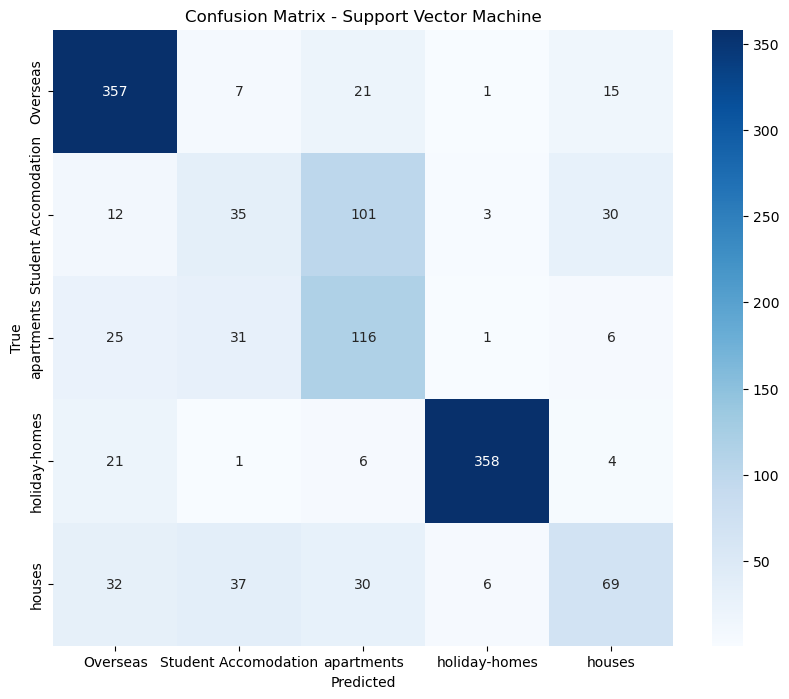

In [19]:
# Evaluating the SVM model
y_pred = svm_classifier.predict(X_test_tfidf_selected)
accuracy_svm = accuracy_score(y_test, y_pred)
print("Accuracy of Support Vector Machine:", round(accuracy_svm*100,2),"%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generating confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy of Logistic Regression: 70.34 %
Classification Report:
                      precision    recall  f1-score   support

            Overseas       0.80      0.88      0.84       401
Student Accomodation       0.32      0.27      0.29       181
          apartments       0.46      0.55      0.50       179
       holiday-homes       0.94      0.92      0.93       390
              houses       0.56      0.43      0.49       174

            accuracy                           0.70      1325
           macro avg       0.61      0.61      0.61      1325
        weighted avg       0.70      0.70      0.70      1325



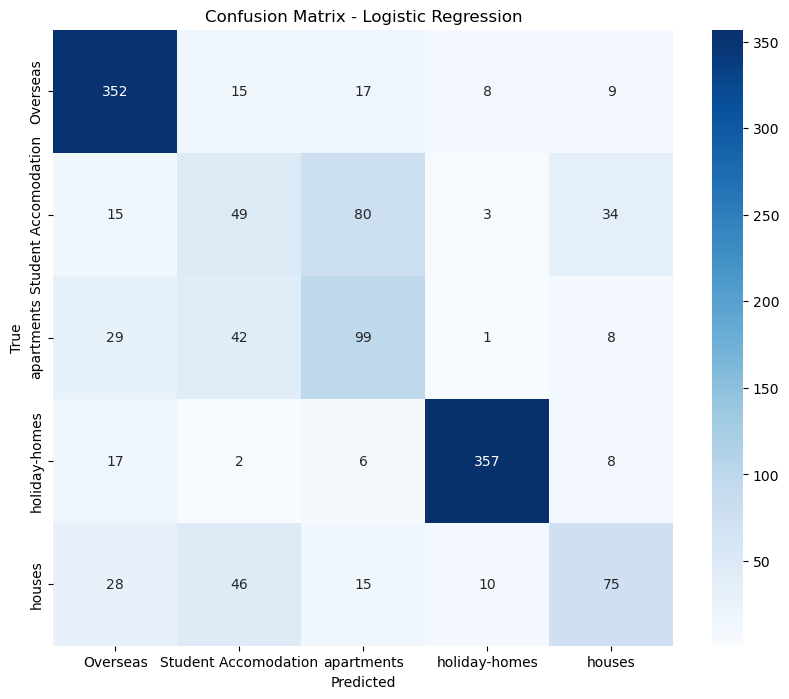

In [20]:
# Evaluating the Logistic Regression model
y_pred = logistic_regression.predict(X_test_tfidf_selected)
accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy of Logistic Regression:", round(accuracy_lr*100,2),"%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generating confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=logistic_regression.classes_, yticklabels=logistic_regression.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7) Results Visualisation
A comparison graph of testing accuracy and precision score for different models is plotted using matplotlib.

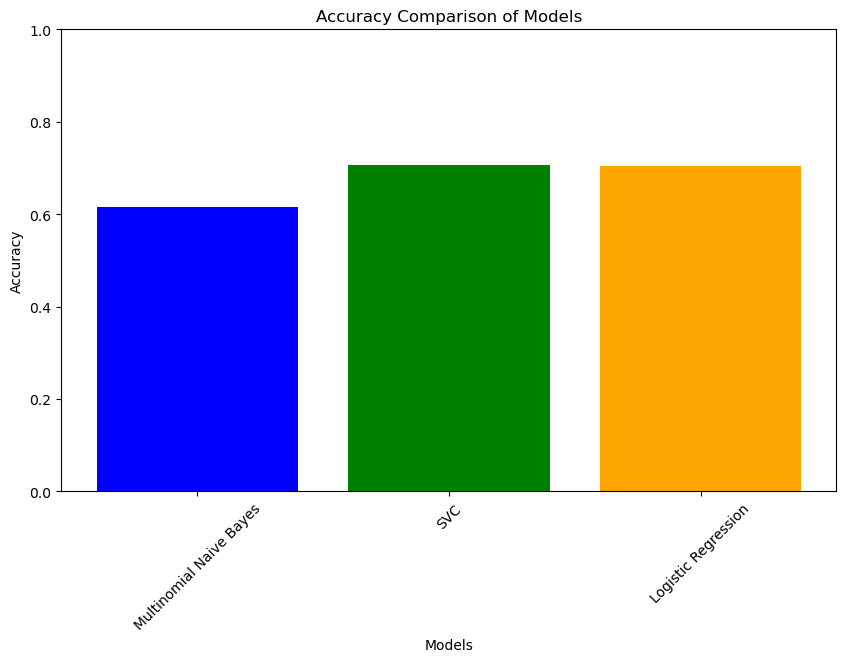

In [21]:
# Accuracy scores for each model
accuracy_scores = [accuracy_nb, accuracy_svm, accuracy_lr]

# Model names
model_names = ['Multinomial Naive Bayes', 'SVC', 'Logistic Regression']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'orange'])
plt.title('Accuracy Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Setting y-axis limit between 0 and 1 for accuracy scores
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Analysis
1) Naive Bayes achieved a moderate accuracy of 61.66%, suggesting its capability to discern patterns in textual data.
2) SVM outperformed the other models with an accuracy of 70.57%, indicating its strength in classifying descriptions into distinct categories.
3) However, Logistic Regression yielded a slightly lower accuracy of 70.34%, implying potential challenges in capturing the nuanced features of property descriptions.

Despite variations in performance, all models exhibited reasonable accuracies, highlighting their potential utility in automating property categorization tasks. Further optimization and refinement may enhance the predictive capabilities of these models for real-world applications in property listing platforms.

# Recommendations
1. With an accuracy of 61.66%, the Naive Bayes model demonstrates decent performance in classifying property descriptions. It may be selected for classification tasks where moderate accuracy is acceptable, and computational efficiency is desired. Additionally, its simplicity and effectiveness in handling text data make it suitable for scenarios where rapid deployment and interpretability are prioritized.
2. The SVM model outperformed the other models with an accuracy of 70.57%. It is recommended for classification tasks where higher accuracy and robust performance are essential. SVMs excel in handling complex datasets and can effectively identify patterns in textual data, making them suitable for applications requiring precise classification of property listings.
3. Despite yielding a slightly lower accuracy of 70.34%, Logistic Regression can still be valuable in certain contexts. It may be preferred for tasks where interpretability and simplicity are prioritized over predictive accuracy. However, its relatively lower performance suggests that it may not be the best choice for classifying property descriptions compared to SVM model.

# Business Value and Inference
1. Enhanced User Experience: By accurately categorizing property listings, businesses can provide users with a more tailored and streamlined experience. This can lead to increased user satisfaction, improved engagement, and higher conversion rates.
2. Improved Search and Recommendation Systems: Accurate classification enables the development of advanced search and recommendation systems. Users can easily find properties that match their preferences, leading to increased user engagement and retention.
3. Totaliy bypassing manually classifying the property and help bsuiness to catergory property in most calcusted and accurater way.
4. The implementation of precise algorithms significantly reduces errors and inconsistencies in property categorization, improving accuracy when showcasing properties on websites.